In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../wanpy")

from wanpy import *
from pythtb import *
from wpythtb import *
import models
import numpy as np
import matplotlib.pyplot as plt

/Users/treycole/Repos/WanPy/tutorials


Setting up `pythTB` tight-binding model

In [2]:
delta = 1
t0 = 0.3
tprime = 0.1
n_super_cell = 2

model = models.checkerboard(t0, tprime, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

# model.display()

## Band Structure

We can easily look at the band structure by calling `Model.plot_bands`, giving a list of high-symmetry points in reduced units, and optional plot configurations.

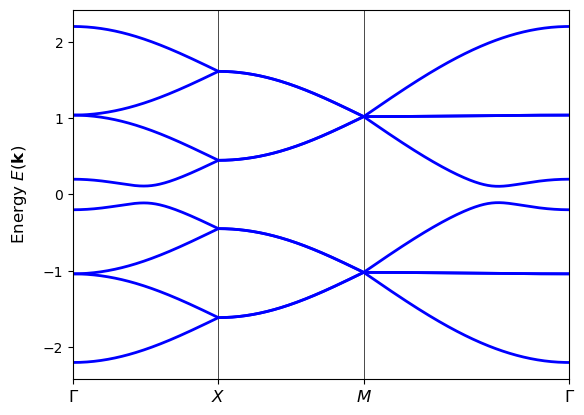

In [3]:
k_path = [[0, 0], [0.5, 0], [.5, .5], [0,0]]
k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
fig, ax = model.plot_bands(k_path, k_label=k_label, nk=501)

## `Bloch` class

To store the eigenstates we will use the `Bloch` class. 
- This is a variant to the `pythtb.wf_array` class with aditional methods useful for manipulating Bloch states. 
- A `Bloch` instance takes as its first argument a `pythtb.model`, followed by the number of k-points along each reciprocal lattice basis vector just as with `pythtb.wf_array`

In [4]:
nks = 20, 20
bloch = Bloch(model, nks[0], nks[1])

A `Bloch` instance has a `K_mesh` class instance as an attribute. The `K_mesh` class stores a regular array of k-points in reduced units, along which the Bloch states are defined. To see the k-mesh points in reduced units, we can call `K_mesh.square_mesh` or `K_mesh.flat_mesh`. 
- The number of axes in the square mesh depends on the dimension of k-space. It has a shape `(nk1, ..., nkd, dim_k)`
- The flat mesh has two axes with shape `(nk1*nk2*...*nkd, dim_k)`

In [5]:
k_mesh = bloch.k_mesh
square_mesh = k_mesh.square_mesh
flat_mesh = k_mesh.flat_mesh

print(f"Dimension of k-mesh: {k_mesh.dim}")
print(f"Number of k-points along each k-space direction: {k_mesh.nks}")
print(f"Total number of k-points: {k_mesh.Nk}")
print()
print("Square k-mesh shape: ", square_mesh.shape)
print("Square k-mesh value at (3, 5): ", square_mesh[3, 5])
print("Square k-mesh value at the last point: ", square_mesh[-1, -1])
print()
print("Flat k-mesh shape: ", flat_mesh.shape)
print("Flat k-mesh value at 3*20 + 5 = (65): ", flat_mesh[65])
print("Flat k-mesh value at the last point: ", flat_mesh[-1])

Dimension of k-mesh: 2
Number of k-points along each k-space direction: (20, 20)
Total number of k-points: 400

Square k-mesh shape:  (20, 20, 2)
Square k-mesh value at (3, 5):  [0.15 0.25]
Square k-mesh value at the last point:  [0.95 0.95]

Flat k-mesh shape:  (400, 2)
Flat k-mesh value at 3*20 + 5 = (65):  [0.15 0.25]
Flat k-mesh value at the last point:  [0.95 0.95]


The `K_mesh` also keeps track of the reciprocal lattice vectors, which can be directly accessed as a class attribute

In [9]:
k_mesh.recip_lat_vecs

array([[3.14159265, 0.        ],
       [0.        , 3.14159265]])

One of the useful features of `K_mesh` is its class function for finding a shell of nearest neighbor k-points. `get_k_shell` will nearest neighbors of a given depth for a given reciprocal lattice. It returns the reciprocal space vectors connecting neighboring k-points, and an array of integer-valued vectors that index neighboring points in the k-mesh.

In [10]:
dks, didxs = k_mesh.get_k_shell(N_sh=1)
print(f"delta_k vectors: \n {dks[0]}")
print(f"delta_idx vectors: \n {didxs[0]}")

delta_k vectors: 
 [[-0.15707963  0.        ]
 [ 0.         -0.15707963]
 [ 0.          0.15707963]
 [ 0.15707963  0.        ]]
delta_idx vectors: 
 [[-1  0]
 [ 0 -1]
 [ 0  1]
 [ 1  0]]


To initialize the Bloch energy eigenstates of the model as class attributes, we will call the `solve_model` method. This stores the eigenstates on a regular k-mesh excluding the endpoints. The periodic boundary conditions are handled internally.

In [11]:
bloch.solve_model()

We can retrieve the eigenstates in either their cell-periodic ($u_{n, \mathbf{k}}$) or full Bloch ($\psi_{n, \mathbf{k}} = e^{i \mathbf{k} \cdot \mathbf{r}} u_{n, \mathbf{k}}$) form using the `get_states` method. This returns a dictionary, with keys "Cell periodic" and "Bloch" whose values are the associated eigenstates.

In [8]:
eigstates = bloch.get_states()
u_nk = eigstates["Cell periodic"]
psi_nk = eigstates["Bloch"]

print("Shape of u_nk: ", u_nk.shape)
print("Shape of psi_nk: ", psi_nk.shape)
print("Value of u_nk with n = 0 and k = (0,0): ", "\n", u_nk[0,0,0,:].round(5))
print("Value of psi_nk with n = 0 and k = (0,0): ", "\n", psi_nk[0,0,0,:].round(5))
print("Value of u_nk with n = 1 and k = (0.15, 0.25): ", "\n", u_nk[3,5,1,:].round(5))
print("Value of psi_nk with n = 1 and k = (0.15, 0.25): ", "\n", psi_nk[3,5,1,:].round(5))

Shape of u_nk:  (20, 20, 8, 8)
Shape of psi_nk:  (20, 20, 8, 8)
Value of u_nk with n = 0 and k = (0,0):  
 [ 0.5-0.j -0. -0.j  0.5-0.j  0. +0.j  0.5+0.j  0. -0.j  0.5+0.j  0. +0.j]
Value of psi_nk with n = 0 and k = (0,0):  
 [ 0.5+0.j -0. -0.j  0.5-0.j  0. +0.j  0.5+0.j  0. -0.j  0.5+0.j  0. +0.j]
Value of u_nk with n = 1 and k = (0.15, 0.25):  
 [-0.49681+0.j      -0.03573-0.04362j  0.49681+0.j       0.03573+0.04362j
 -0.49681+0.j      -0.03573-0.04362j  0.49681-0.j       0.03573+0.04362j]
Value of psi_nk with n = 1 and k = (0.15, 0.25):  
 [-0.49681+0.j      -0.00327-0.0563j   0.3513 +0.3513j  -0.0375 +0.04212j
 -0.44266-0.22555j  0.02265-0.05164j  0.15352+0.47249j -0.05253+0.0205j ]


We are able to compute Berry phases and Berry curvatures conveniently. To obtain the full Berry curvature tensor for all planes, we call `berry_curv`. To restrict to a given plane, we can pass a 2-tuple to `dirs` specifying the plane. We additionally provide the band indices that are traced over through `state_idx`

In [9]:
Berry_curvature = bloch.berry_curv(dirs=(0,1), state_idx=np.arange(n_occ))

Let's look at the Berry curvature distribution. To do so, we translate the indices to reciprocal space coordinates by first retrieving the reciprocal space vectors using `model.get_recip_lat_vecs`, then forming a grid from the k-mesh.

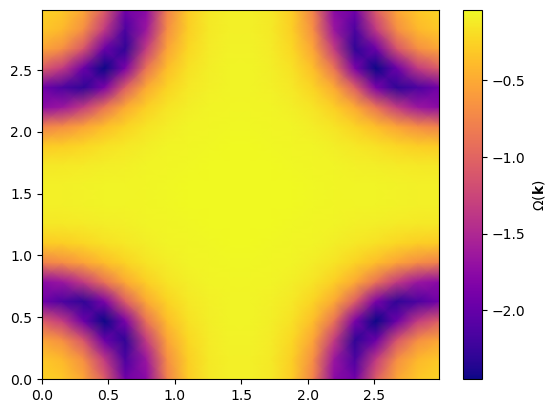

In [10]:
recip_lat_vecs = model.get_recip_lat_vecs()
mesh_Cartesian = square_mesh @ recip_lat_vecs

kxs, kys = mesh_Cartesian[:, :, 0], mesh_Cartesian[:, :, 1]
im = plt.pcolormesh(kxs, kys, Berry_curvature.real, cmap='plasma', shading='gouraud')
plt.colorbar(label=r'$\Omega(\mathbf{k})$')

The Chern number is easily found for a given set of bands. It is again assumed that the band indices are for the lower half of states (occupied).

In [14]:
chern = bloch.chern_num()
print(f"Chern number: {chern:0.1f}")

Chern number: -1.0
